<center>
<img src="https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/img/this_is_data_anal.png" width="200" height="200"><br>
</center>

# ch04. 데이터 분류 모델

## 4.1 타이타닉의 생존자 가려내기

타이타닉의 생존자 그룹과 비생존자 그룹을 분류하는 예제를 4단계 step으로 살펴보자.
타이타닉 데이터셋의 구성은 다음과 같다.


- pclass : Passenger Class, 승객 등급
- survived : 생존 여부
- name : 승객 이름
- sex : 승객 성별
- age : 승객 나이
- sibsp : 탑승 한 형제/배우자 수
- parch : 탑승 한 부모/자녀 수
- ticket : 티켓 번호
- fare : 승객 지불 요금
- cabin : 선실 이름
- embarked : 승선항 (C = 쉘 부르그, Q = 퀸즈타운, S = 사우스 햄튼)
- body : 사망자 확인 번호
- home.dest : 고향/목적지

분석에 사용할 데이터는 총 2개의 파일로 구성되어 있다.(데이터 출처 : https://github.com/yoonkt200/python-data-analysis)
하나는 분류 모델의 학습을 위한 학습 데이터셋, 그리고 나머지 하나는 테스트를 위한 테스트 데이터셋입니다. 그리고 각 데이터의 age, cabin, body, home.dest 피처에는 결측치가 존재한다. 

- 타이타닉 데이터셋의 기본 정보 구하기

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv("/home/jaeyoon89/python-data-analysis/data/titanic_train.csv")
df_test = pd.read_csv("/home/jaeyoon89/python-data-analysis/data/titanic_test.csv")

In [2]:
df_train.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [4]:
print(df_train.info())
print("---------------")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     916 non-null    int64  
 1   survived   916 non-null    int64  
 2   name       916 non-null    object 
 3   sex        916 non-null    object 
 4   age        741 non-null    float64
 5   sibsp      916 non-null    int64  
 6   parch      916 non-null    int64  
 7   ticket     916 non-null    object 
 8   fare       916 non-null    float64
 9   cabin      214 non-null    object 
 10  embarked   914 non-null    object 
 11  body       85 non-null     float64
 12  home.dest  527 non-null    object 
dtypes: float64(3), int64(4), object(6)
memory usage: 93.2+ KB
None
---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     393 non-nu

먼저 name. ticket, body, home.dest, cabin 피처를 제거한다. 이 피처들은 지금 당장 분석에 활용할 수 없거나 큰 의미를 가지고 있지 않은 피처이기 때문이다.

- 불필요한 피처 제거하기

In [5]:
df_train = df_train.drop(['name','ticket','body','cabin','home.dest'], axis=1)
df_test = df_test.drop(['name','ticket','body','cabin','home.dest'], axis=1)

다음으로 각 피처가 분류 분석에 미칠 영향에 대해 탐색해 보자. 이를 탐색하는 가장 좋은 방법은 데이터를 그룹(생존자/비생존자)으로 나누어 피처의 그룹 간 차이를 탐색하는 것이다. 생존 여부(생존=1, 아닌 경우=0)인 survived를 그룹으로 하여 pclass 피처의 그룹별 분포를 출력한 결과는 아래와 같다. seaborn의 countplot이라는 함수를 사용하자.

- 탐색적 데이터 분석하기

0    563
1    353
Name: survived, dtype: int64


<AxesSubplot:>

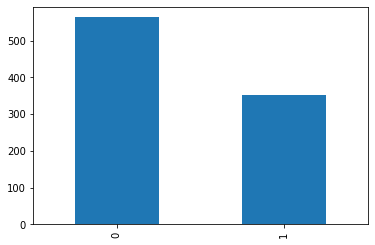

In [8]:
print(df_train['survived'].value_counts())
df_train['survived'].value_counts().plot.bar()

3    498
1    230
2    188
Name: pclass, dtype: int64


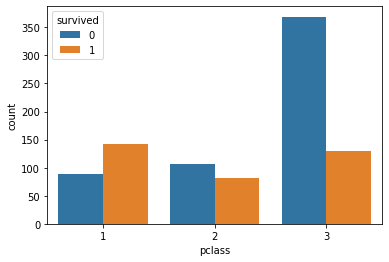

In [9]:
print(df_train['pclass'].value_counts())
ax = sns.countplot(x='pclass', hue = 'survived', data=df_train)

다음으로 age, sibsp와 같은 수치형 피처들에 대한 탐색을 진행한다. 다음의 코드는 이러한 피처들을 탐색할 수 있는 자동화 함수 valid_features()를 작성한 것이다 함수의 실행 내용은 다음과 같다.

- 두 그룹 간의 분포를 비교하는 그래프를 출력한다.
- 두 그룹 각각의 표준편차를 출력한다.
- 두 그룹 간의 T-test 검정을 실시하여 출력한다.
- 두 그룹 각각에 Shapiro-wilk 검정을 실시하여 출력한다.

- 변수 탐색작업 자동화하기

In [13]:
from scipy import stats
def valid_features(df, col_name, distribution_check=True):
    g =  sns.FacetGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30)    
    
    titanic_survived = df[df['survived']==1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print("data std is", '%.2f' % np.std(titanic_survived_static))
    titanic_n_survived = df[df['survived']==0]
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print("dat std is", '%.2f' % np.std(titanic_n_survived_static))
    
    tTestResult = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var=False)
    print("The t-statistic and p-value assuming equal variances is %.3f and %.3f." % tTestResult)
    print("The t-statistic and p-value not assuming equal variances is %.3f and %.3f" % tTestResultDiffVar)
    
    if distribution_check:
        print("The w-statistic and p-value in Survived %.3f and %.3f" % stats.shapiro(titanic_survived[col_name]))
        print("The w-statistic and p-value in Non-Survived %.3f and %.3f" % stats.shapiro(titanic_n_survived[col_name]))

- 자동화 함수 실행하기

data std is 14.22
dat std is 13.71
The t-statistic and p-value assuming equal variances is -0.546 and 0.585.
The t-statistic and p-value not assuming equal variances is -0.543 and 0.587
The w-statistic and p-value in Survived 0.982 and 0.001
The w-statistic and p-value in Non-Survived 0.968 and 0.000
data std is 0.64
dat std is 1.34
The t-statistic and p-value assuming equal variances is -2.118 and 0.034.
The t-statistic and p-value not assuming equal variances is -2.446 and 0.015


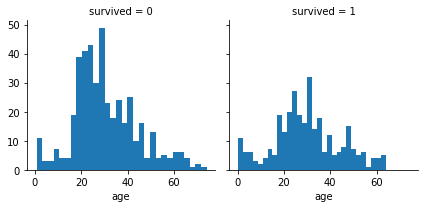

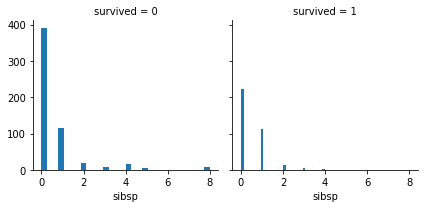

In [14]:
valid_features(df_train[df_train['age'] > 0], 'age', distribution_check=True)
valid_features(df_train, 'sibsp', distribution_check=False)

분석 결과, age 피처는 두 그룹 간의 평균 차이가 없기 때문에 생존자 분류에 미치는 영향력이 낮을것이라고 가정해볼 수 있다. 반면 sibsp 피처에서는 두 그룹 간의 평균 차이가 어느정도 존재한다는 것을 알 수 있다.

### step.2 분류: 생존자 분류 모델 만들기

이제 분류 모델을 만들어 보자. 예측 모델과 마찬가지로 분류 모델 역시 다양한 방법이 존재한다.
첫 번째로 시도해볼 방법은 로지스틱 회귀 모델을 이용한 분류이다. 로지스틱 회귀 모델은 기존 회귀 분석의 예측값 Y를 0 ~ 1 사이의 값으로 제한하여 0.5보다 크면 1, 작으면 0이라고 분류하는 방법이다. 로지스틱 회귀 모델은 일반적인 회귀 모델과 마찬가지로 계수 분석을 통한 피처의 영향력 해석이 용이하다는 장점이 있다. 로지스틱 모델을 사용하기 위해 회귀 분석을 수행할 때와 동일한 방법으로 데이터를 가공한다. 우선 결측값을 처리한다. 결측값이 존재하는 피처를 전처리하는 방법은 크게 두 가지이다.

- 1. 결측이 존재하는 데이터들을 삭제하는 방법
- 2. 평균값, 혹은 중앙값이나 최빈값 등의 임의의 수치로 채워 넣는 방법

1은 처리가 쉽고 분석에서의 주관이 개입될 여지가 없다는 장점이 있다. 하지만 중요한 정보를 삭제하게 될 수 있다. 2는 데이터를 모두 분석에 활용할 수 있다는 장점이 있지만 수치 왜곡의 가능성이 있다는 단점이 있다. 아래는 2를 이용해여 age와 embark 피처의 결측값을 보정했다.

- 분류 모델을 위해 전처리하기

In [15]:
replace_mean = df_train[df_train['age'] > 0]['age'].mean()
df_train['age'] = df_train['age'].fillna(replace_mean)
df_test['age'] = df_test['age'].fillna(replace_mean)

embarked_mode = df_train['embarked'].value_counts().index[0]
df_train['embarked'] = df_train['embarked'].fillna(embarked_mode)
df_test['embarked'] = df_test['embarked'].fillna(embarked_mode)

whole_df = df_train.append(df_test)
train_idx_num = len(df_train)

whole_df_encoded = pd.get_dummies(whole_df)
df_train = whole_df_encoded[:train_idx_num]
df_test = whole_df_encoded[train_idx_num:]

df_train.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,1,0,0,0,1
1,2,1,4.000000,1,1,23.0000,1,0,0,0,1
2,2,1,30.000000,1,0,13.8583,1,0,1,0,0
3,3,0,30.231444,0,0,7.7250,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,1,0,0,1,0


이제 sklearn 모듈의 LogisticRegression 클래스로 모델을 학습하자.

- 분류 모델링 : 로지스틱 회귀 모델

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

/home/jaeyoon89/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


그렇다면 이 모델이 생존자를 얼마나 잘 분류하는지는 어떻게 평가할까? 일반적으로 분류 모델의 평가 기준은 Confusion Matrix라는 것을 활용한다.

F1-score는 정밀도와 재현도의 조화 평균값으로, 두 값을 동시에 고려할 때 사용하는 지표이다. 그리고 ROC Curve는 재현도와 특이도를 고려하여 종합적인 모델의 성능을 그래프로 나타내는 것인데 이 값이 1에 가까울수록 좋은 분류 모델이다.

다음의 코드는 정확도, 정밀도, 특이도, F1-score 네 가지 지표로 모델을 평가한 것이다.

- 분류 모델 평가하기

In [21]:
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.80
Precision : 0.756
Recall : 0.673
F1 : 0.712


그리고 다음의 코드는 Confusion Matrix를 직접 출력한 것이다.

In [22]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[214  32]
 [ 48  99]]


마지막으로 AUC를 출력해보자. AUC 출력은 분류 결과인 0 혹은 1의 y값(y_pred)을 사용하는 것이 아니라, 분류 직전의 확률값(y_pred_probability)인 0 ~ 1 사이의 값을 사용해야 한다.

- 로지스틱 회귀 모델의 AUC 구하기

AUC : 0.838


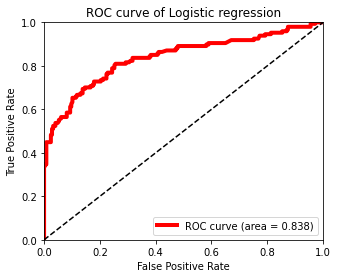

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

아래의 코드와 실행 결과는 로지스틱 회귀 모델과 더불어 분류 분석의 가장 대표적인 방법인 의사 결정 나무 모델을 적용한 결과이다. 하지만 로지스틱 회귀 모델에 비해 모든 평가 지표가 낮은 것을 확인할 수 있다.

- 의사결정 나무

In [26]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
y_pred_probability = dtc.predict_proba(x_test)[:,1]

print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.74
Precision : 0.669
Recall : 0.619
F1 : 0.643


AUC : 0.733


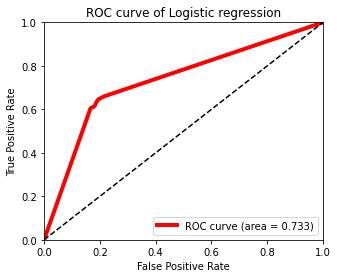

In [27]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")